In [1]:
%matplotlib inline

In [2]:
import os
import random
import csv
import copy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import wandb
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

dataset_path = Path(r'C:\Users\LIBDL-2\Documents\21BCAF50\Anime Recommendation System')

output_path = Path(r'C:\Users\LIBDL-2\Documents\21BCAF50\Anime Recommendation System\output')

In [3]:
 #Get appropriate device for training
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device')

Using cpu device


In [4]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash('setting random seeds') % 2**32 - 1)
np.random.seed(hash('improves reproducibility') % 2**32 - 1)
torch.manual_seed(hash('by removing stochasticity') % 2**32 - 1)
torch.cuda.manual_seed_all(hash('so runs are repeatable') % 2**32 - 1)

In [5]:
# Initialize Weights and Biases
wandb.init()


wandb.login(key="0a2567b6cada724d766774b3094636b5e265f8b7")



wandb: Currently logged in as: pradeeparjunsam. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [6]:
reviews = pd.read_csv(dataset_path/'reviews.csv', usecols=['profile', 'anime_uid', 'score'])
reviews.head()

,profile,anime_uid,score
0,DesolatePsyche,34096,8
1,baekbeans,34599,10
2,skrn,28891,7
3,edgewalker00,2904,9
4,aManOfCulture99,4181,10


In [7]:
animes = pd.read_csv(dataset_path/'animes.csv', usecols=['uid', 'title'])
animes.head()

,uid,title
0,28891,Haikyuu!! Second Season
1,23273,Shigatsu wa Kimi no Uso
2,34599,Made in Abyss
3,5114,Fullmetal Alchemist: Brotherhood
4,31758,Kizumonogatari III: Reiketsu-hen


In [8]:
# Add anime titles to dataframe
reviews = pd.merge(reviews, animes, left_on='anime_uid', right_on='uid')
reviews

,profile,anime_uid,score,uid,title
0,DesolatePsyche,34096,8,34096,Gintama.
1,DesolatePsyche,34096,8,34096,Gintama.
2,claudinou,34096,8,34096,Gintama.
3,claudinou,34096,8,34096,Gintama.
4,PeterFromRussia,34096,8,34096,Gintama.
...,...,...,...,...,...
317474,Kuromizue,9751,9,9751,Strike Witches Movie
317475,ryanxwonbin,9751,8,9751,Strike Witches Movie
317476,AobaSuzukaze,9751,10,9751,Strike Witches Movie
317477,7jaws7,9751,9,9751,Strike Witches Movie


In [9]:
#Data Exploration

In [10]:
cross_tabulation = pd.crosstab(reviews.profile, reviews.title, reviews.score, aggfunc=np.sum)

In [11]:
user_groups = reviews.groupby('profile').score.count()
top_users = user_groups.sort_values(ascending=False)[:10].keys()

anime_groups = reviews.groupby('title').score.count()
top_animes = anime_groups.sort_values(ascending=False)[:10].keys()

cross_tabulation.loc[top_users, top_animes]

title,Death Note,Steins;Gate,Kimi no Na wa.,Fullmetal Alchemist: Brotherhood,Clannad: After Story,Toradora!,Mahou Shoujo Madoka★Magica,Mirai Nikki,Tengen Toppa Gurren Lagann,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.
profile,,,,,,,,,,
Stark700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN
Sidewinder51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ktulu007,NaN,28.0,NaN,32.0,NaN,20.0,36.0,NaN,24.0,28.0
LegendAqua,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ggultra2764,NaN,NaN,24.0,24.0,NaN,NaN,32.0,16.0,NaN,NaN
literaturenerd,24.0,NaN,NaN,28.0,NaN,NaN,20.0,16.0,NaN,NaN
BanjoTheBear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BabyGirl06301,36.0,32.0,36.0,40.0,NaN,NaN,NaN,28.0,NaN,NaN
PyraXadon,28.0,NaN,NaN,NaN,40.0,NaN,36.0,NaN,NaN,36.0


(array([ 4870.,  5164., 10229., 10909., 16495., 24766., 39624., 57463.,
        70498., 77461.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

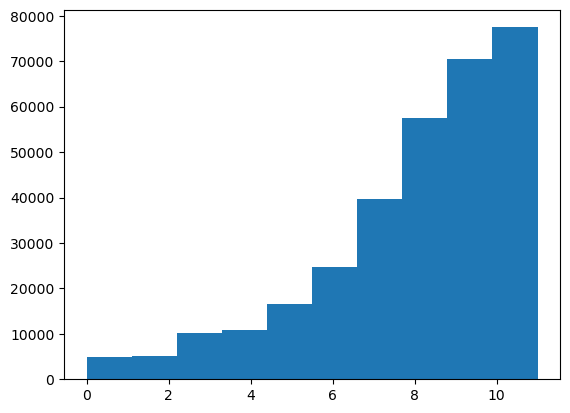

In [12]:
plt.hist(reviews.score)

In [13]:
#Create DataLoaders

In [14]:
unique_users = reviews.profile.unique()
user_to_index = {}
for index, user in enumerate(unique_users):
    user_to_index[user] = index
        
unique_animes = reviews.title.unique()
anime_to_index = {}
index_to_anime = {}
for index, anime in enumerate(unique_animes):
    anime_to_index[anime] = index
    index_to_anime[index] = anime

In [15]:
class ReviewDataset(Dataset):
    '''
    A class for a Pytorch dataset that stores users, animes, and scores.
    '''
    
    def __init__(self, dataframe, user_to_index, anime_to_index):
        # Convert users to integers
        user_indexes = dataframe.profile.map(user_to_index)
        
        # Convert animes to integers
        anime_indexes = dataframe.title.map(anime_to_index)
            
        self.X = pd.DataFrame({'user_index': user_indexes, 'anime_index': anime_indexes})
        self.y = dataframe.score.astype(np.intc)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = torch.tensor(self.X.iloc[index], dtype=torch.int32).to(device)
        y = torch.tensor([self.y.iloc[index]], dtype=torch.float32).to(device)
        return X, y

In [16]:
train_reviews, test_reviews = train_test_split(reviews, test_size=0.2, random_state=42)
validation_reviews, test_reviews = train_test_split(test_reviews, test_size=0.5, random_state=42)
train_reviews

,profile,anime_uid,score,uid,title
196752,samuel_sfx,14741,9,14741,Chuunibyou demo Koi ga Shitai!
210305,Popaglockin,120,5,120,Fruits Basket
213579,Zyzoxing,31859,9,31859,Hai to Gensou no Grimgar
204607,azuslu7jpg,10357,9,10357,Jinrui wa Suitai Shimashita
29003,JyoStar,400,10,400,Seihou Bukyou Outlaw Star
...,...,...,...,...,...
119879,ratchet573,5081,8,5081,Bakemonogatari
259178,Lord_Odous,10793,6,10793,Guilty Crown
131932,LacePendragon,13601,9,13601,Psycho-Pass
146867,Tozzy,32,9,32,Neon Genesis Evangelion: The End of Evangelion


In [17]:
#Modeling

In [18]:
class CollaborativeFilteringNeuralNetwork(nn.Module):
    '''
    Creates a neural network with embedding layers.
    
    Arguments:
        num_users:
            Number of unique users
            
        num_items:
            Number of unique items
            
        num_factors:
            Number of latent factors for each user and item
            
        hiddens:
            A list of integers defining the number of units in each hidden layer.
            
        embedding_dropout:
            Dropout rate to apply after embeddings layer
            
        dropouts:
            List of dropout rates to apply after each hidden layer
    '''
    
    def __init__(self, num_users, num_items, num_factors, hiddens, embedding_dropout, dropouts):
        super().__init__()
        
        def generate_layers(num_in):
            '''
            Generator that creates layers
            '''
            
            for num_out, dropout in zip(hiddens, dropouts):
                yield nn.Linear(num_in, num_out)
                yield nn.ReLU()
                if dropout > 0.:
                    yield nn.Dropout(dropout)
                num_in = num_out
                
            # Output layer
            yield nn.Linear(num_in, 1)
            yield nn.Sigmoid()
                
        self.user_embeddings = nn.Embedding(num_users, num_factors)
        self.item_embeddings = nn.Embedding(num_items, num_factors)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.linear_relu_stack = nn.Sequential(*list(generate_layers(num_factors * 2)))
        
    def forward(self, x):
        user_embeddings = self.user_embeddings(x[:, 0])
        item_embeddings = self.item_embeddings(x[:, 1])
        nn_input = torch.cat((user_embeddings, item_embeddings), dim=1)
        nn_input = self.embedding_dropout(nn_input)
        nn_output = self.linear_relu_stack(nn_input)
        return nn_output

In [19]:
#Train Model

In [20]:
import csv

def export_anime_indexes(file_name, index_to_anime):
    with open(file_name, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        # Write header
        writer.writerow(['Index', 'Anime'])

        # Write key-value pairs
        for index, anime in index_to_anime.items():
            writer.writerow([index, anime])

    print('Anime indexes CSV exported!')

def model_pipeline(init_arguments):
    with wandb.init(**init_arguments):
        config = wandb.config
        
        # Make datasets
        train_dataset = ReviewDataset(train_reviews, user_to_index, anime_to_index)
        validation_dataset = ReviewDataset(validation_reviews, user_to_index, anime_to_index)
        test_dataset = ReviewDataset(test_reviews, user_to_index, anime_to_index)

        # Make dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True)
        
        # Make model
        num_users = len(unique_users)
        num_items = len(unique_animes)
        model = CollaborativeFilteringNeuralNetwork(
            num_users, 
            num_items, 
            config.latent_factors, 
            config.hidden_layers,
            config.embedding_dropout,
            config.dropouts
        ).to(device)
        
        loss_function = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)

        print('💪 Training! ≧◡≦\n')
        train(train_dataloader, validation_dataloader, model, config.epochs, loss_function, optimizer, config.patience)
        
        print('🧪 Testing! ≧◡≦\n')
        test(test_dataloader, model, loss_function, False)
        
        print('📦 Exporting! ≧◡≦\n')
        
        # Export model
        sample_users = torch.randint(len(unique_users), (config.batch_size, 1))
        sample_animes = torch.randint(len(unique_animes), (config.batch_size, 1))
        sample_input = torch.cat((sample_users, sample_animes), 1)
        sample_input = sample_input.to(device)
        export_model(model, sample_input, 'model.onnx')
        
        # Export anime indexes
        export_anime_indexes('anime_indexes.csv', index_to_anime)
        
        # Export anime embeddings
        anime_embeddings = model.item_embeddings.weight
        export_anime_embeddings(anime_embeddings, 'anime_embeddings.csv')

        return model, anime_embeddings




In [21]:
def train(dataloader, validation_dataloader, model, epochs, loss_function, optimizer, patience):
    '''
    Training loop.
    '''
    
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, loss_function, log='all', log_freq=10)
    
    examples_seen = 0
    best_validation_loss = np.inf
    best_weights = None
    # Put model in training mode. Important for batch normalization and dropout
    model.train()
    
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch+1}\n-------------------------------')
        
        for batch, (X, y) in enumerate(dataloader):
            loss = train_batch(X, y, model, loss_function, optimizer)
            examples_seen += len(X)

            # Report metrics every couple of batches
            if batch % 200 == 0:
                train_log(loss, examples_seen, epoch)
                
        # Validate model after each epoch
        validation_loss = test(validation_dataloader, model, loss_function, True)
        
        # Early stopping
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_weights = copy.deepcopy(model.state_dict())
            no_improvements_streak = 0
        else:
            no_improvements_streak = 1
            
        if no_improvements_streak >= patience:
            print(f'Early stopping after {epoch} epochs')
            break;
            
    model.load_state_dict(best_weights)

In [22]:
def train_batch(X, y, model, loss_function, optimizer):
    '''
    Trains a single batch.
    '''
    
    # Move tensors to device
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    predictions = model(X) * 10
    loss = loss_function(predictions, y)

    # Backpropogation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [23]:
def train_log(loss, examples_seen, epoch):
    '''
    Print progress and save metrics to Weights and Biases
    '''
    
    wandb.log({'epoch': epoch, 'loss': loss}, step=examples_seen)
    print(f'Training loss after {examples_seen:>5d} examples: {loss:>7f}')

In [24]:
def test(dataloader, model, loss_function, isValidation):
    '''
    Does validation/testing.
    '''

    num_batches = len(dataloader)
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            # Move tensors to device
            X, y = X.to(device), y.to(device)
            
            # Compute prediction error
            predictions = model(X) * 10
            
            # Compute loss and accuracy
            loss += loss_function(predictions, y).item()
            
            
    loss /= num_batches
    
    if isValidation:
        wandb.log({'validation_loss': loss})
        print(f'Validation Error: \n Validation loss: {loss:>8f} \n')
    else:
        wandb.log({'test_loss': loss})
        print(f'Test Error: \n Test loss: {loss:>8f} \n')
        
    return loss

In [25]:
def export_model(model, sample_input, file_name):
    torch.onnx.export(model, sample_input, file_name)
    wandb.save(str(output_path/file_name))
    print('Model exported!')

In [26]:
def export_anime_embeddings(anime_embeddings, file_name):
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)

        for row in anime_embeddings:
            writer.writerow(row.tolist())

    wandb.save(str(output_path/file_name))
    print('Anime embeddings CSV exported!')

In [27]:
config = {
    'architecture': 'Neural Collaborative Filtering',
    'epochs': 100,
    'batch_size': 2000,
    'hidden_layers': [500, 500, 500],
    'learning_rate': 1e-3,
    'latent_factors': 150,
    'embedding_dropout': 0.05,
    'dropouts': [0.5, 0.5, 0.25],
    'patience': 10
}

In [28]:
init_arguments = {
    'project': 'anime-collaborative-filtering-system',
    'config': config,
    'name': 'serious',
    'notes': "I'm using the whole dataset and serious parameters this time!"
}

In [29]:
with open('anime_indexes.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([index, anime])


In [30]:
# Build, train, and analyze the model with the pipeline
model, anime_embeddings = model_pipeline(init_arguments)

💪 Training! ≧◡≦



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Training loss after  2000 examples: 12.545751
Validation Error: 
 Validation loss: 5.147820 

Epoch 2
-------------------------------
Training loss after 255983 examples: 4.956694
Validation Error: 
 Validation loss: 4.742447 

Epoch 3
-------------------------------
Training loss after 509966 examples: 4.619745
Validation Error: 
 Validation loss: 4.727514 

Epoch 4
-------------------------------
Training loss after 763949 examples: 4.683920
Validation Error: 
 Validation loss: 4.712062 

Epoch 5
-------------------------------
Training loss after 1017932 examples: 4.794420
Validation Error: 
 Validation loss: 4.701651 

Epoch 6
-------------------------------
Training loss after 1271915 examples: 4.840333
Validation Error: 
 Validation loss: 4.683162 

Epoch 7
-------------------------------
Training loss after 1525898 examples: 4.689947
Validation Error: 
 Validation loss: 4.674245 

Epoch 8
-------------------------------
Training loss after

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model exported!
Anime indexes CSV exported!
Anime embeddings CSV exported!


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
test_loss,▁
validation_loss,█▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
epoch,99
loss,2.91589
test_loss,3.32689
validation_loss,3.36217


In [32]:
anime = 'Serial Experiments Lain'
anime_index = anime_to_index[anime]

#The [None] adds a new dimension with size 1
anime_embedding = anime_embeddings[anime_index][None]

embedding_distances = nn.CosineSimilarity(dim=1)(anime_embeddings, anime_embedding)
similar_anime_indexes = embedding_distances.argsort(descending=True)[1:6].tolist()

print(f'Similar animes to {anime}:')
for rank, index in enumerate(similar_anime_indexes):
    print(f'{rank + 1}. {index_to_anime[index]}')

Similar animes to Serial Experiments Lain:
1. Wo Shi Jiang Xiaobai
2. Tennis no Ouji-sama Movie 1: Futari no Samurai - The First Game
3. Extra
4. Futari wa Milky Holmes
5. Shokugeki no Souma: San no Sara - Kyokuseiryou no Erina
